In [42]:
!pip  install -r ./requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2
import se2_flow
import numpy as np
import matplotlib.pyplot as plt


In [2]:
se2_flow.solve_control_gain()

(array([[-3.16227766, -0.        , -0.        ],
        [-0.        , -3.16227766, -4.04036574]]),
 array([[1, 0],
        [0, 0],
        [0, 1]]),
 array([[-3.16227766,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ],
        [ 0.        , -3.16227766, -4.04036574]]))

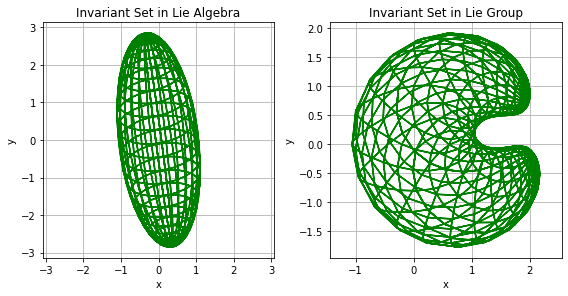

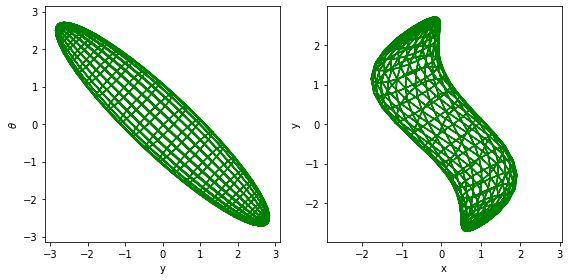

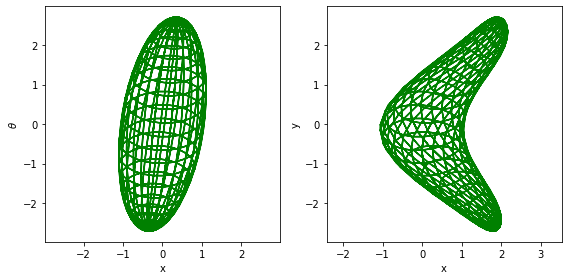

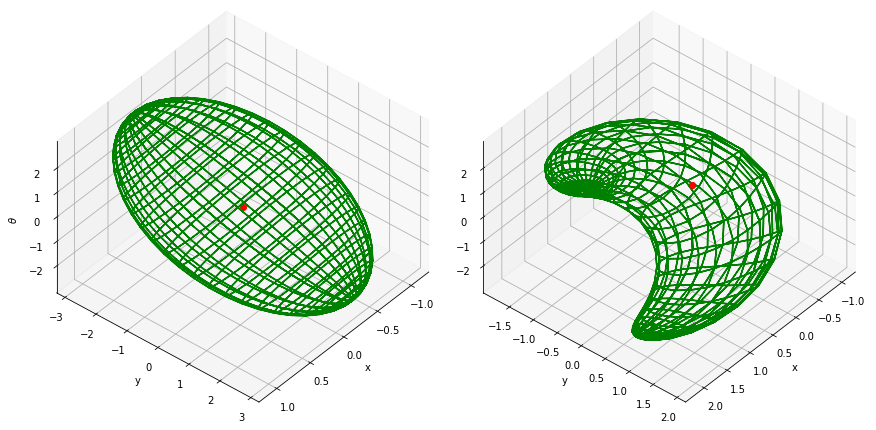

In [3]:
sol = se2_flow.find_se2_invariant_set()
se2_flow.plot_invariant_set(sol, w1=1, w2=1)

In [4]:
def HJB_invariat(R):
    points = []
    n = 25
    for u in np.linspace(0, 2*np.pi, n):
        for v in np.linspace(0, 2*np.pi, 2*n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    for v in np.linspace(0, 2*np.pi, 2*n):
        for u in np.linspace(0, 2*np.pi, n):
            points.append([np.cos(u)*np.sin(v), np.sin(u)*np.sin(v), np.cos(v)])
    points = np.array(points).T
    return R*np.eye(3)@points

def plot_HJB_invariant_set(R):
    
    e = np.array([0, 0, 0]) # Lie Group
    e0 = se2_flow.se2_log(e) # Lie Algebra

    t = 0
    points = HJB_invariat(R) #Lie Algebra

    exp_points = np.zeros((3,points.shape[1]))
    for i in range(points.shape[1]):
        exp_points[:,i] = se2_flow.SE2_exp_wedge(points[:,i])


    plt.figure(figsize=(8,4))
    ax = plt.subplot(121)
    ax.plot(points[0, :], points[1, :], 'g');
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #ax.plot(e0[0],e0[1],'ro')
    plt.axis('equal')
    plt.grid(True)
    ax2 = plt.subplot(122)
    ax2.plot(exp_points[0, :-1], exp_points[1, :-1], 'g');
    #ax2.plot(e[0],e[1],'ro')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    ax.set_title('Invariant Set in Lie Algebra')
    ax2.set_title('Invariant Set in Lie Group')

    plt.figure(figsize=(8,4))
    ax = plt.subplot(121)
    ax.plot(points[1, :], points[2, :], 'g');
    ax.set_xlabel('y')
    ax.set_ylabel('$\\theta$')
    plt.axis('equal')
    ax2 = plt.subplot(122)
    ax2.plot(exp_points[1, :], exp_points[2, :], 'g');
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.axis('equal')
    plt.tight_layout()

    plt.figure(figsize=(8,4))
    ax = plt.subplot(121)
    ax.plot(points[0, :], points[2, :], 'g');
    ax.set_xlabel('x')
    ax.set_ylabel('$\\theta$')
    plt.axis('equal')
    ax2 = plt.subplot(122)
    ax2.plot(exp_points[0, :], exp_points[2, :], 'g');
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.axis('equal')
    plt.tight_layout()

    plt.figure(figsize=(12,6))
    ax = plt.subplot(121, projection='3d', proj_type='ortho', elev=40, azim=40)
    ax.plot3D(e0[0], e0[1], e0[2], 'ro');
    ax.plot3D(points[0, :], points[1, :], points[2, :],'g');
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('$\\theta$')
    plt.axis('auto')
    ax2 = plt.subplot(122, projection='3d', proj_type='ortho', elev=40, azim=40)
    ax2.plot3D(e[0], e[1], e[2], 'ro');
    ax2.plot3D(exp_points[0, :], exp_points[1, :], exp_points[2, :], 'g');
    ax2.plot3D(e[0], e[1], e[2], 'ro');
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.axis('auto')
    plt.tight_layout()

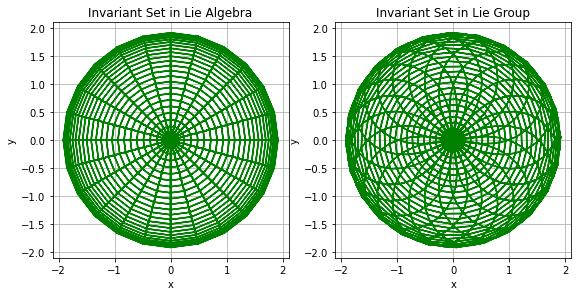

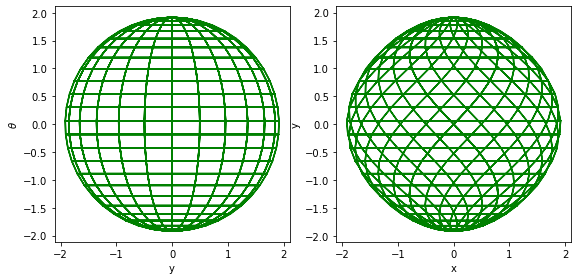

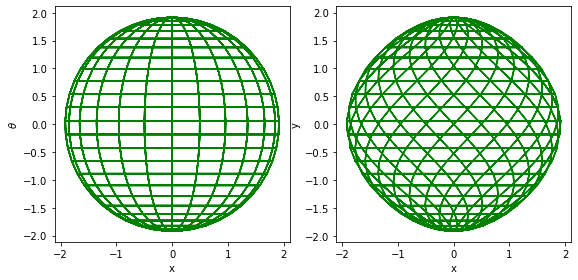

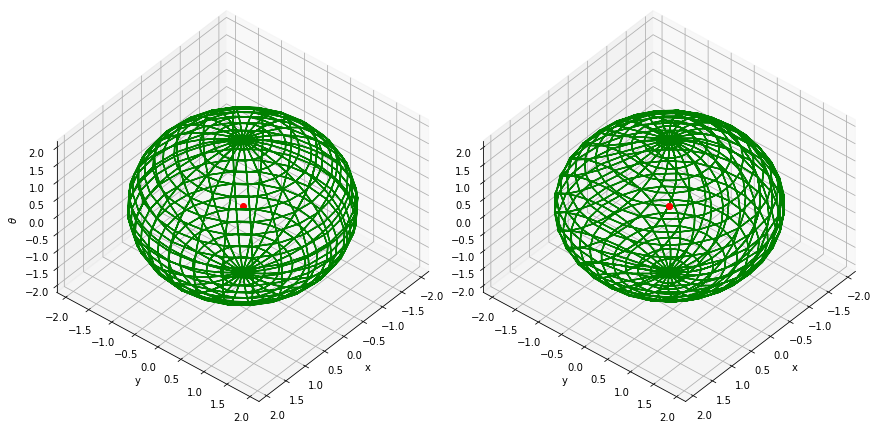

In [5]:
plot_HJB_invariant_set(1.9177) # U as 3x3 Identity

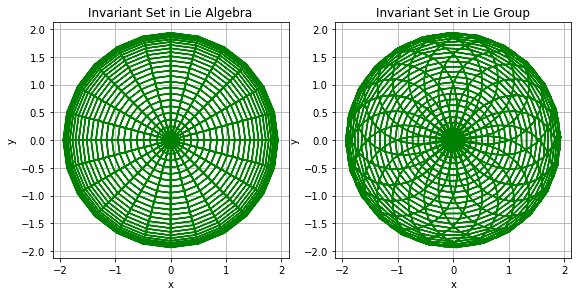

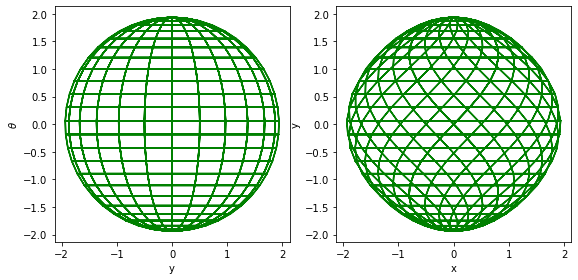

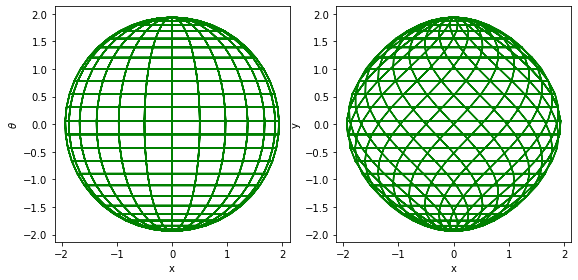

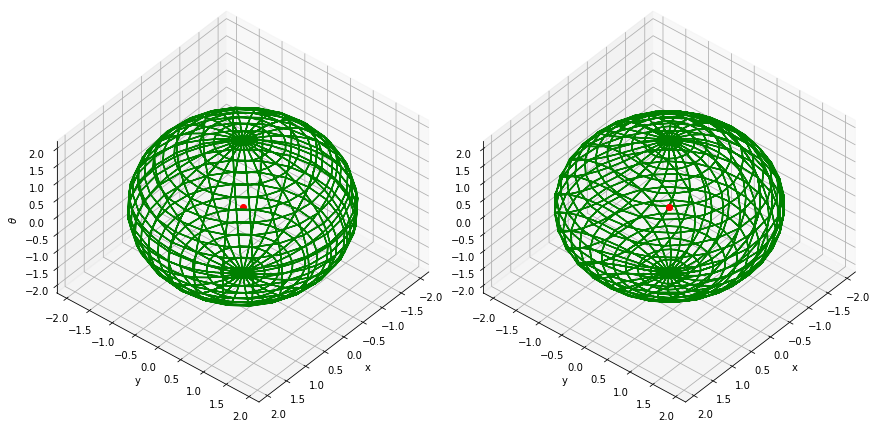

In [6]:
plot_HJB_invariant_set(1.9374) # U using taylor expansion

In [7]:
sol

{'cost': 1.4586142557417117,
 'prob': <Semidefinite Program>,
 'mu1': 0.923674551103837,
 'mu2': 0.5349397046378745,
 'P': array([[ 2.721, -0.017, -0.351],
        [-0.017,  1.875,  1.751],
        [-0.351,  1.751,  2.07 ]]),
 'alpha': (1.0616070002359541+0j),
 'gam': <1×1 Real Linear Expression: mu_1 + mu_2>}

# Flow Pipes Simulation

In [2]:
t = 40
n = 10 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
sol1 = se2_flow.find_se2_invariant_set() # u, v, w1, w2

ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e0 = se2_flow.se2_log(np.array([0, 0, -np.pi/10]))

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol1)

#TEB_small = circ_inv(1.476) # HJB w/ control bound [-pi,pi]
#L_small = circ_inv(1.4487) # lyapunov w/ small theta_max
#L_large = circ_inv(2.1136) # lyapunov w/ large theta_max
#flow_pipes_Ls, intervalhull_Ls, nom, ang = flowpipes(res,L_small,t, n)
#flow_pipes_Ll, intervalhull_Ll, nom = flowpipes(xr,r_large,t, n)
#flow_pipes_Hs, intervalhull_Hs, nom, ang = flowpipes(res,TEB_small,t, n)
#flow_pipes_Hl, intervalhull_Hl, nom = flowpipes(xr,TEB,t, n)

[3.94596359 0.07824113]
[5.40718974 3.35724485]
[5.40719865 7.35724464]
[ 4.04382343 10.71575458]
[ 0.0499877  10.81448671]
[-3.94598314 10.73624448]
[-5.4072314   7.45725648]
[-5.40726658  3.45725639]
[-4.04390927  0.0987749 ]
[-5.00608683e-02 -2.18711380e-05]


Text(0, 0.5, 'y')

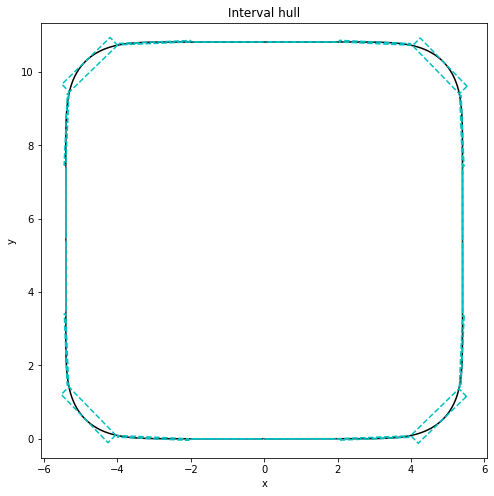

In [9]:
# interval hull
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(intervalhull_LMI[facet][:,0], intervalhull_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_Ls = ax.plot(intervalhull_Ls[facet][:,0], intervalhull_Ls[facet][:,1], color='m', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Interval hull')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_Ls[0]], ['nominal', 'interval hull'], loc=1);

NameError: name 'nom' is not defined

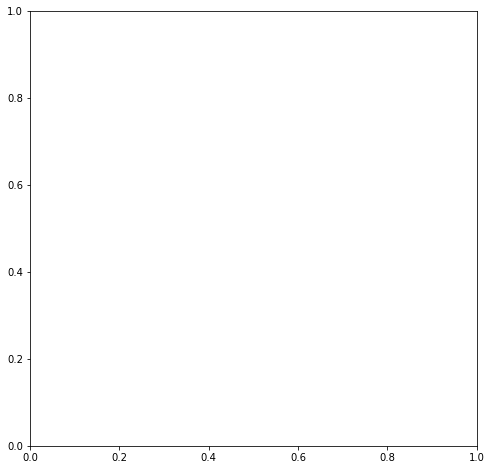

In [4]:
# flow pipes
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_LMI = ax.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='c', linestyle='--')
    #hs_ch_LMI_L = ax.plot(flow_pipes_LMI_L[facet][:,0], flow_pipes_LMI_L[facet][:,1], color='y', linestyle='--')
    #hs_ch_Hs = ax.plot(flow_pipes_Hs[facet][:,0], flow_pipes_Hs[facet][:,1], color='m', linestyle='--', alpha = 0.5)

plt.axis('equal')
plt.title('Flow Pipes')
plt.xlabel('x')
plt.ylabel('y')
#legend([h_nom[0], hs_ch_LMI[0], hs_ch_LMI_L[0]], ['nominal', 'flow pipe (small)', 'flow pipe (Large)'], loc=1);

# Trajectories simulation

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


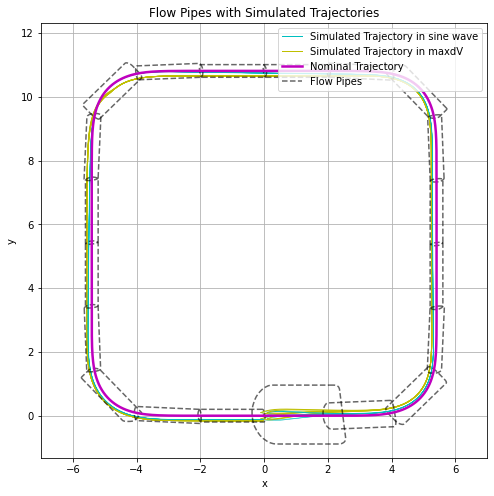

In [7]:
# small distrubance
freq = [0.02] #, .04, .06, .08, .01, .03, .05, .07, .09]
res = []
t = 40
n = 20 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)
e = []
V=[]

for theta0 in np.linspace(-np.pi/10, np.pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = np.array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        se2_flow.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        se2_flow.plot_simulated(r2, name='maxdV', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        se2_flow.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        se2_flow.plot_simulated(r2, name='', legend=False, save=False, linewidth = 1, color = 'y')
                        
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.6)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 2.5)

plt.axis('equal')
plt.xlim([-7, 7])
plt.ylim([-3, 14])
plt.title('Flow Pipes with Simulated Trajectories')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[ 0.          0.         -0.31415927]


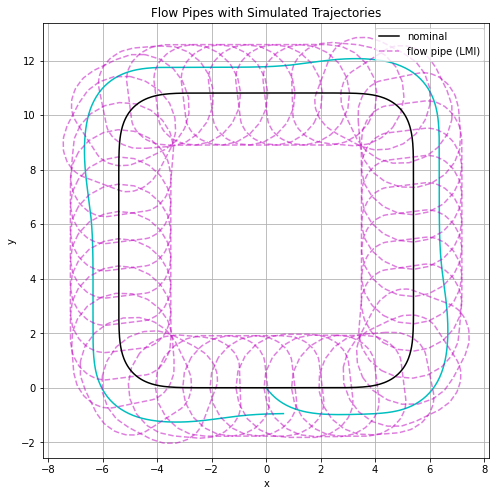

In [8]:
# large disturbance
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
freq = [0.02]
res = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


init_e = np.array([[0, 0, -np.pi/10]]).T 
V0 = init_e.T@sol['P']@init_e
for i in freq:
    r = se2_flow.simulate(tf=40, freq_d=i, w1_mag=w1, w2_mag=w2, x0=init_e[0], y0=init_e[1], theta0=init_e[2], dist='maxdV', sol= sol1, use_approx=False)
    se2_flow.plot_simulated(r, color='c', name='sine wave', legend=True, save=False)
    res.append(r)
                
e0 = se2_flow.se2_log(init_e.reshape(3,))
print(e0)
flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='m', linestyle='--', alpha = 0.5)
    
h_nom = plt.plot(nom[:,0], nom[:,1], color='k', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes with Simulated Trajectories')
plt.xlabel('x')
plt.ylabel('y')
plt.legend([h_nom[0], hs_ch_LMI[0]], ['nominal', 'flow pipe (LMI)'], loc=1);

# Application Example

In [10]:
V2 = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])
P2 = se2_flow.Polytope(V2)
p4 = (4, 6)
P3 = P2*1.5 + (0,8.5)
P4 = P2 + p4
rot_mat5 = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)],
                     [np.sin(np.pi/4), np.cos(np.pi/4)]])
P5 = 0.5*rot_mat5*P3 -(1, 0)

In [20]:
P4.V

array([[5., 6.],
       [4., 5.],
       [3., 6.],
       [4., 7.]])

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


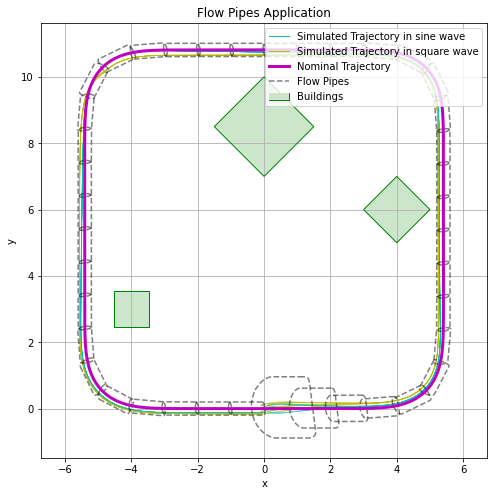

In [8]:
#freq = [0.02, .04, .06, .08, .01]
freq = [0.02]

res = []
e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = .1
w2 = .1  
ref = se2_flow.simulate(t, 0, w1, w2, 0, 0, 0, dist='sine', sol= sol1, use_approx=False)


for theta0 in np.linspace(-np.pi/10, np.pi/10, 2):
    for x0 in np.linspace(-.1, .1, 2):
        for y0 in np.linspace(-.1, .1, 2):
                init_e = np.array([[x0, y0, theta0]]).T
                V0 = init_e.T@sol['P']@init_e
                V.append(V0)
                e.append(init_e)
                for i in freq:
                    r = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                    r2 = se2_flow.simulate(40, i, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                    res.append(r)
                    if theta0 == np.pi/10 and x0 == .1 and y0 == .1 and i == freq[-1]:
                        se2_flow.plot_simulated(r, name='sine wave', legend=True, save=False, linewidth = 1, color = 'c')
                        se2_flow.plot_simulated(r2, name='square wave', legend=True, save=False, linewidth = 1, color = 'y')
                    else:
                        se2_flow.plot_simulated(r, name='', legend=False, save=False, linewidth = .5, color = 'c')
                        se2_flow.plot_simulated(r2, name='', legend=False, save=False, linewidth = .5, color = 'y')
                
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

B1 = P4.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P3.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)
P5.plot(facecolor=(0.8,.9,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-', linewidth = 3)

plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(B1)
labels.append('Buildings')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())

[[ 0.1       ]
 [-0.1       ]
 [-0.31415927]]
[ 0.11488414 -0.08346821 -0.31415927]


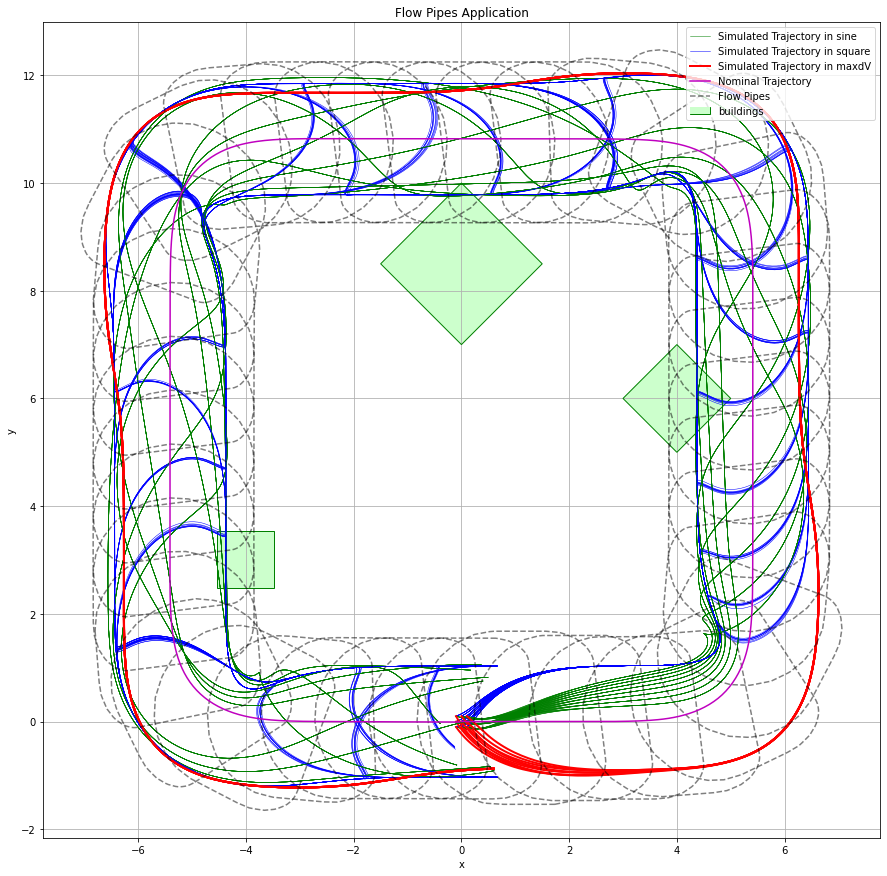

In [11]:
freq = [0.02, .04, .06, .08, .01, .03, .05, .07, .09]
plt.figure(figsize=(15, 15))

e = []
V = []
t = 40
n = 40 # number of interval hulls
# disturbances
w1 = 1
w2 = 1
ref = se2_flow.simulate(t, 0, 0, 0, 0, 0, 0, dist='none', sol= sol1, use_approx=False)

cnt = 0
for theta0 in np.arange(-np.pi/10, np.pi/10, np.pi/4):
    for x0 in np.linspace(-.1, .1, 3):
        for y0 in np.linspace(-.1, .1, 3):
            cnt += 1
            init_e = np.array([[x0, y0, theta0]]).T
            V0 = init_e.T@sol['P']@init_e
            V.append(V0)
            e.append(init_e)
            for i, f in enumerate(freq):
                r = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='sine', sol= sol1, use_approx=False)
                r2 = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='square', sol= sol1, use_approx=False)
                legend = cnt == 1 and i == 0
                se2_flow.plot_simulated(r, name='sine', legend=legend, save=False, linewidth = .5, color = 'g', alpha = 1)
                se2_flow.plot_simulated(r2, name='square', legend=legend, save=False, linewidth = .5, color = 'b', alpha = 1)
                
                # want to draw last so it is on top
                if i == len(freq) - 1:
                    r3 = se2_flow.simulate(t, f, w1, w2, x0, y0, theta0, dist='maxdV', sol= sol1, use_approx=False)
                    se2_flow.plot_simulated(r3, name='maxdV', legend=(cnt==1), save=False, linewidth = 2, color = 'r', alpha = 1)
        
i = np.array(V).argmax()
print(e[i])
e0 = se2_flow.se2_log(np.array(e[i]).reshape(3,))
print(e0)

flow_pipes_LMI, intervalhull_LMI, nom = se2_flow.flowpipes(ref, t, n, e0, w1, w2, sol)
for facet in range(n):
    hs_ch_LMI = plt.plot(flow_pipes_LMI[facet][:,0], flow_pipes_LMI[facet][:,1], color='k', linestyle='--', alpha = 0.5)

B1 = P4.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
B2 = P3.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)
B3 = P5.plot(facecolor=(0.8,1,0.8), edgecolor='g', linewidth=1)


h_nom = plt.plot(nom[:,0], nom[:,1], color='m', linestyle='-')

plt.axis('equal')
plt.title('Flow Pipes Application')
plt.xlabel('x')
plt.ylabel('y')

lgd = plt.legend(loc=1)
ax = lgd.axes
handles, labels = ax.get_legend_handles_labels()
handles.append(h_nom[0])
labels.append('Nominal Trajectory')
handles.append(hs_ch_LMI[0])
labels.append('Flow Pipes')
handles.append(B1)
labels.append('buildings')
lgd._legend_box = None
lgd._init_legend_box(handles, labels)
lgd._set_loc(lgd._loc)
lgd.set_title(lgd.get_title().get_text())
plt.savefig('figures/maxdV.png')

In [21]:
n2 = 40
points = se2_flow.se2_lie_algebra_invariant_set_points(sol, t, w1, w2, e0) #Lie Algebra

exp_points = np.zeros((3,points.shape[1]))
for i in range(points.shape[1]):
    exp_points[:,i] = se2_flow.SE2_exp_wedge(points[:,i])
flow_pipes3d_s, intervalhull_s, nom = se2_flow.flowpipes3d(ref,exp_points,t, n2)

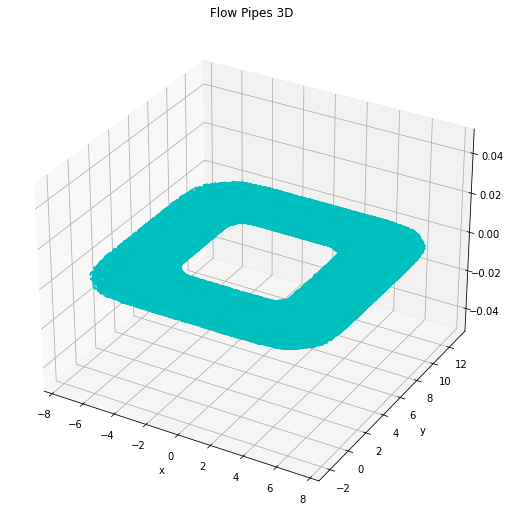

In [22]:
plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n2):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')

plt.title('Flow Pipes 3D')
plt.xlabel('x')
plt.ylabel('y');